## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.
- study the sentiment of news about some emerging notion : metaverse (in cathefories and NER) maybe something else.
## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [79]:
import os
import csv
import json
import nltk
import spacy 
import shutil
import gcloud
import requests
import requests
import matplotlib
import numpy as np
import pandas as pd
import urllib.request
import networkx as nx
from PIL import Image
from spacy import displacy
from tqdm.notebook import *
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm
nltk.download('punkt')

2021-12-20 14:35:32.441251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-12-20 14:35:32.441524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oussama\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# I- Fetching data :

Used to fetch news data using an original scrapper, including published images, so they be injected into the model as additional features  

In [3]:
def scrap_one_article(url, _, nbr_articles):
    try:
        dirName = 'images'
        os.mkdir(dirName)
    except:
        pass
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url_clean)
    soup = BeautifulSoup(response.text, 'lxml')
    csv_file = open('bbc_news.csv', 'a')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['id', 'url', 'author', 'article_content'])
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    print('url: ',url_clean)
    print('fetched the name of author :')
    print("fetched the article's content : ",article_content[:100],f' +[{len(article_content)-100}] chars ',)    
    img_count = download_images(soup,_,nbr_articles)
    article_dic= {'id': _ ,'url': url_clean,'author':None,'article_content':article_content,'Image count': img_count}
    return article_dic

In [4]:
def build_text(list_):
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name):
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def get_links_list(soup):
        results = soup.find_all('a',class_ = 'gs-c-promo-heading')
        links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
        return links_list


In [5]:
def scrap_bbc_articles(category_url):
    try:    
        shutil.rmtree('images') 
    except:
        pass
    url = category_url
    response = requests.get(url)
    print('Request status (200 means a succesful request): ',response.status_code)
    soup = BeautifulSoup(response.text, 'lxml')
    links = get_links_list(soup)
    print('fetching begun ...')
    try: 
        csv_file = open('bbc_news.csv', 'a')
        print('Csv file created under the name bbc_news.csv')
    except: 
        pass
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['id', 'link', 'Author', 'Article content', 'publishing date' ])
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    for _ in range(1,len(links)-5):  # Covers all the articles len(links)+1
        print('------------------------------------')
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            pass
    csv_file.close()
    return results


In [6]:
climate_url = 'https://www.bbc.com/news/science-environment-56837908'
data = scrap_bbc_articles(climate_url)
def fetch_clean_data(data_list): 
    article_results = [] 
    for i in range(len(data_list)):
        try:
            article_dict = {}
            article_dict['id'] = data_list[i]['id']
            article_dict['author'] = data_list[i]['author']
            article_dict['url'] = data_list[i]['url']
            article_dict['article_content'] = data_list[i]['article_content'].strip("\n").strip("\t")
            article_results.append(article_dict)
        except IndexError:
            pass
    return article_results

Request status (200 means a succesful request):  200
fetching begun ...
Csv file created under the name bbc_news.csv
Fetching data from  38  bbc news articles
------------------------------------
url:  http://www.bbc.com//news/world-australia-59390798
fetched the name of author :
fetched the article's content :  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in a hi  +[7902] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59649066
fetched the name of author :
fetched the article's content :  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, soun  +[2976] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59644494
fetched the name of author :
fetched the article's content :  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially  +[4396] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58913875
fetched the name of author :
fetched the article's content :  Making your home more energy efficient can be costly and may not be possible if you're renting, or y  +[4568] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59387191
fetched the name of author :
fetched the article's content :  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by  +[5473] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-asia-59525480
fetched the name of author :
fetched the article's content :  It's a glorious autumn afternoon and I'm standing on a hillside looking out over Tokyo Bay. Beside m  +[6720] chars 
12



------------------------------------
url:  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776
fetched the name of author :
fetched the article's content :  Business leaders have warned that thousands of oil and gas jobs could be at risk in the UK after She  +[6015] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-australia-59390798
fetched the name of author :
fetched the article's content :  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in a hi  +[7902] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59649066
fetched the name of author :
fetched the article's content :  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, soun  +[2976] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59644494
fetched the name of author :
fetched the article's content :  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially  +[4396] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58913875
fetched the name of author :
fetched the article's content :  Making your home more energy efficient can be costly and may not be possible if you're renting, or y  +[4568] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59387191
fetched the name of author :
fetched the article's content :  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by  +[5473] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-asia-59525480
fetched the name of author :
fetched the article's content :  It's a glorious autumn afternoon and I'm standing on a hillside looking out over Tokyo Bay. Beside m  +[6720] chars 
12



------------------------------------
url:  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776
fetched the name of author :
fetched the article's content :  Business leaders have warned that thousands of oil and gas jobs could be at risk in the UK after She  +[6015] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59649066
fetched the name of author :
fetched the article's content :  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, soun  +[2976] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59644494
fetched the name of author :
fetched the article's content :  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially  +[4396] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58913875
fetched the name of author :
fetched the article's content :  Making your home more energy efficient can be costly and may not be possible if you're renting, or y  +[4568] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59387191
fetched the name of author :
fetched the article's content :  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by  +[5473] chars 
12



------------------------------------
url:  http://www.bbc.com//news/world-asia-59525480
fetched the name of author :
fetched the article's content :  It's a glorious autumn afternoon and I'm standing on a hillside looking out over Tokyo Bay. Beside m  +[6720] chars 
12



------------------------------------
url:  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776
fetched the name of author :
fetched the article's content :  Business leaders have warned that thousands of oil and gas jobs could be at risk in the UK after She  +[6015] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-56901261
fetched the name of author :
fetched the article's content :  A new global agreement - the Glasgow Climate Pact - was reached at the COP26 summit.
It aims to redu  +[4387] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59212185
fetched the name of author :
fetched the article's content :  As the COP26 climate summit enters its second week, negotiations in Glasgow have hit a critical phas  +[5829] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59036722
fetched the name of author :
fetched the article's content :  It's the end of week one at the COP26 climate conference in Glasgow, and world leaders have already   +[12545] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59136545
fetched the name of author :
fetched the article's content :  World leaders have pledged to end and reverse deforestation by 2030.
But in Brazil's Amazon rainfore  +[4397] chars 
12



------------------------------------
url:  http://www.bbc.com//news/59135899
fetched the name of author :
fetched the article's content :  There has been criticism of the number of world leaders and other delegates who have travelled to th  +[4784] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-24021772
fetched the name of author :
fetched the article's content :  World temperatures are rising because of human activity, and climate change now threatens every aspe  +[5414] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58954530
fetched the name of author :
fetched the article's content :  Scientists and politicians say we are facing a planetary crisis because of climate change. 
But what  +[4649] chars 
12



------------------------------------
------------------------------------
url:  http://www.bbc.com//news/science-environment-46459714
fetched the name of author :
fetched the article's content :  Avoiding meat and dairy products is one of the biggest ways to reduce your environmental impact, acc  +[7140] chars 
------------------------------------
url:  http://www.bbc.com//news/science-environment-58874518
fetched the name of author :
fetched the article's content :  Countries have set out plans to cut greenhouse gas emissions, at the COP26 climate change summit in   +[4356] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-59241053
fetched the name of author :
fetched the article's content :  Re-flooding coastal wetlands could provide an opportunity to "work with nature" and use sea level ri  +[2035] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-58399809
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[4403] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-57149747
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[3031] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-56225862
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[5732] chars 
12



------------------------------------
url:  http://www.bbc.com//news/science-environment-56902340
fetched the name of author :
fetched the article's content :  In our monthly feature, Then and Now, we reveal some of the ways that planet Earth has been changing  +[3648] chars 
12



------------------------------------
https://www.bbc.com/future/article/20211214-doughnuts-the-fried-treat-that-conquered-the-modern-world
------------------------------------
https://www.bbc.com/worklife/article/20211209-the-6-biggest-lessons-about-work-from-2021


In [7]:
Data = pd.DataFrame.from_dict(fetch_clean_data(data))
pd.set_option('max_colwidth', 500)
Data.head()

id author                                                    url  \
0   1   None      http://www.bbc.com//news/world-australia-59390798   
1   2   None  http://www.bbc.com//news/science-environment-59649066   
2   3   None  http://www.bbc.com//news/science-environment-59644494   
3   4   None  http://www.bbc.com//news/science-environment-58913875   
4   5   None                      http://www.bbc.com//news/59387191   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       article_content  
0  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in a historic judgement. Their case has now been appealed by the country's government. If the final verdict swings in their favour, it will have ramifications not just for Australian law but for climate cases world-wide. \nIn May this year, Anjali Sharma was sitting in her economics class at school in Melbourne when the court in Sydney live-streamed the results of a climate case she had found herself...  
1  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, sounding "alarm bells" over Earth's changing climate.\nThe World Meteorological Organization (WMO) on Tuesday verified the record, reported in the Siberian town of Verkhoyansk on 20 June last year. \nThe temperature was 18C higher than the area's average daily maximum for June.\nThe WMO, a UN agency, said the extreme heat was "more befitting the Mediterranean than the Arctic".\nIt is the first tim...  
2  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potentially within the next five to 10 years.\nThey say a floating section at the front of Thwaites Glacier that until now has been relatively stable could "shatter like a car windscreen". \nUS and UK researchers are currently engaged in an intense study programme at Thwaites because of its melt rate. \nAlready it is dumping 50 billion tonnes of ice into the ocean each year.\nThis is having limited impac...  
3  Making your home more energy efficient can be costly and may not be possible if you're renting, or you don't have thousands of pounds stashed away to buy new heat pumps and double glazing.\nBut there are some cheap solutions to try to save money. We've looked at where you are likely to be losing the most energy in your home and come up with some simple solutions to help save money on your bills and keep warm this winter.\nWarm air wants to leave your home and will find any nook and cranny to...  
4  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would peak by 2030 and then start to fall. \nIt's also said that it will end deforestation by that same date.\nBut to reduce emissions from its transport sector, it's relying on using more biofuels - production of which can lead to the loss of forested land.\nSo how can it both curb its emissions using biofuels and end deforestation by 2030?\nIndonesia is now the third largest producer of biofuels in the w...

In [8]:
Data.to_csv('exported_bbc_data.csv')
Data.to_excel('exported_bbc_data.xlsx')

In [9]:
Data.count()

id                 33
author              0
url                33
article_content    33
dtype: int64

<h1> II- Data preprocessing :</h1>

### Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data, including eliminating bad records, encoding variables, scaling variables and finally eliminating
scaling of variables and finally the elimination of variables with a high correlation.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the machine learning models.
the machine learning models and improve their performance, which we will discuss below.
we will discuss below.
### Missing value rate and zero variance
Here we try to eliminate variables with a very high rate of missing values
or zero variance. The following variables are then removed from our final database

In [10]:
Data.columns

Index(['id', 'author', 'url', 'article_content'], dtype='object')

In [11]:
def clean(Data):
    #lower case all content
    Data['article_content'] = Data["article_content"].map(lambda x: x.lower()) 
    #removing punctuation
    punc = '!()-[]{};:"\,<>./?@#$%^&*_~'
    def strip_punc(text):
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")                                                   
        return text
    Data['article_content'] = Data["article_content"].map(lambda x: strip_punc(x)) #lower case all content
clean(Data)
Data.head()

id author  \
0    1   None   
1    2   None   
2    3   None   
3    4   None   
4    5   None   
5    6   None   
6    7   None   
7    8   None   
8    9   None   
9   10   None   
10  11   None   
11  12   None   
12  13   None   
13  14   None   
14  15   None   
15  16   None   
16  17   None   
17  18   None   
18  19   None   
19  20   None   
20  21   None   
21  22   None   
22  23   None   
23  24   None   
24  25   None   
25  26   None   
26  27   None   
27  30   None   
28  31   None   
29  32   None   
30  33   None   
31  34   None   
32  35   None   

                                                                         url  \
0                          http://www.bbc.com//news/world-australia-59390798   
1                      http://www.bbc.com//news/science-environment-59649066   
2                      http://www.bbc.com//news/science-environment-59644494   
3                      http://www.bbc.com//news/science-environment-58913875   
4                                          http://www.bbc.com//news/59387191   
5                               http://www.bbc.com//news/world-asia-59525480   
6   http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776   
7                          http://www.bbc.com//news/world-australia-59390798   
8                      http://www.bbc.com//news/science-environment-59649066   
9                      http://www.bbc.com//news/science-environment-59644494   
10                     http://www.bbc.com//news/science-environment-58913875   
11                                         http://www.bbc.com//news/59387191   
12                              http://www.bbc.com//news/world-asia-59525480   
13  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776   
14                     http://www.bbc.com//news/science-environment-59649066   
15                     http://www.bbc.com//news/science-environment-59644494   
16                     http://www.bbc.com//news/science-environment-58913875   
17                                         http://www.bbc.com//news/59387191   
18                              http://www.bbc.com//news/world-asia-59525480   
19  http://www.bbc.com//news/uk-scotland-north-east-orkney-shetland-59517776   
20                     http://www.bbc.com//news/science-environment-56901261   
21                     http://www.bbc.com//news/science-environment-59212185   
22                     http://www.bbc.com//news/science-environment-59036722   
23                                         http://www.bbc.com//news/59136545   
24                                         http://www.bbc.com//news/59135899   
25                     http://www.bbc.com//news/science-environment-24021772   
26                     http://www.bbc.com//news/science-environment-58954530   
27                     http://www.bbc.com//news/science-environment-58874518   
28                     http://www.bbc.com//news/science-environment-59241053   
29                     http://www.bbc.com//news/science-environment-58399809   
30                     http://www.bbc.com//news/science-environment-57149747   
31                     http://www.bbc.com//news/science-environment-56225862   
32                     http://www.bbc.com//news/science-environment-56902340   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        article_content  
0   when eight teenagers and an elderly nun in australia teamed up for a climate case they won in a historic judgement their case has now been appealed by the country's government if the final verdi

### NER : Named entities recognition :
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try differnet Nlp models to get NERs from text.
#### 1- Standford Ner :

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [27]:
str_ = str(Data.iloc[5]['article_content']) # sample article
str_

"it's a glorious autumn afternoon and i'm standing on a hillside looking out over tokyo bay beside me is takao saiki a usually mildmannered gentleman in his 70s\nbut today saikisan is angry\nit's a total joke he says in perfect english just ridiculous\nthe cause of his distress is a giant construction site blocking our view across the bay  a 13gigawatt coalfired power station in the making\ni don't understand why we still have to burn coal to generate electricity says saikisan's friend rikuro suzuki this plant alone will emit more than seven million tonnes of carbon dioxide every year\nsuzukisan's point is a good one shouldn't japan be cutting its coal consumption not increasing it at a time of great concern about coal's impact on the climate \nso why the coal the answer is the 2011 fukushima nuclear disaster\nin 2010 about one third of japan's electricity came from nuclear power and there were plans to build a lot more but then the 2011 disaster hit and all japan's nuclear power plant

In [28]:
model = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz"
jar = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/stanford-ner.jar"
st = StanfordNERTagger(model, jar,encoding='utf-8')
java_path = "C:/Program Files/Java/jdk-17.0.1/bin/java.exe" 
os.environ["JAVAHOME"] = java_path

In [29]:
tokenized_text = nltk.word_tokenize(str_)
classified_text = st.tag(tokenized_text)
netagged_words = classified_text
entities = []
labels = []
for tag, chunk in groupby(classified_text, lambda x:x[1]):
    if tag != "O":
        entities.append(' '.join(w for w, t in chunk))
        labels.append(tag)
entities_all = list(zip(entities, labels))
entities_unique = list(set(zip(entities, labels))) #unique entities   
data_entities_1 = pd.DataFrame(entities_unique)
data_entities_1.columns = ["Entities", "Labels"]
data_entities_1


Entities    Labels
0  australia  LOCATION
1      japan  LOCATION

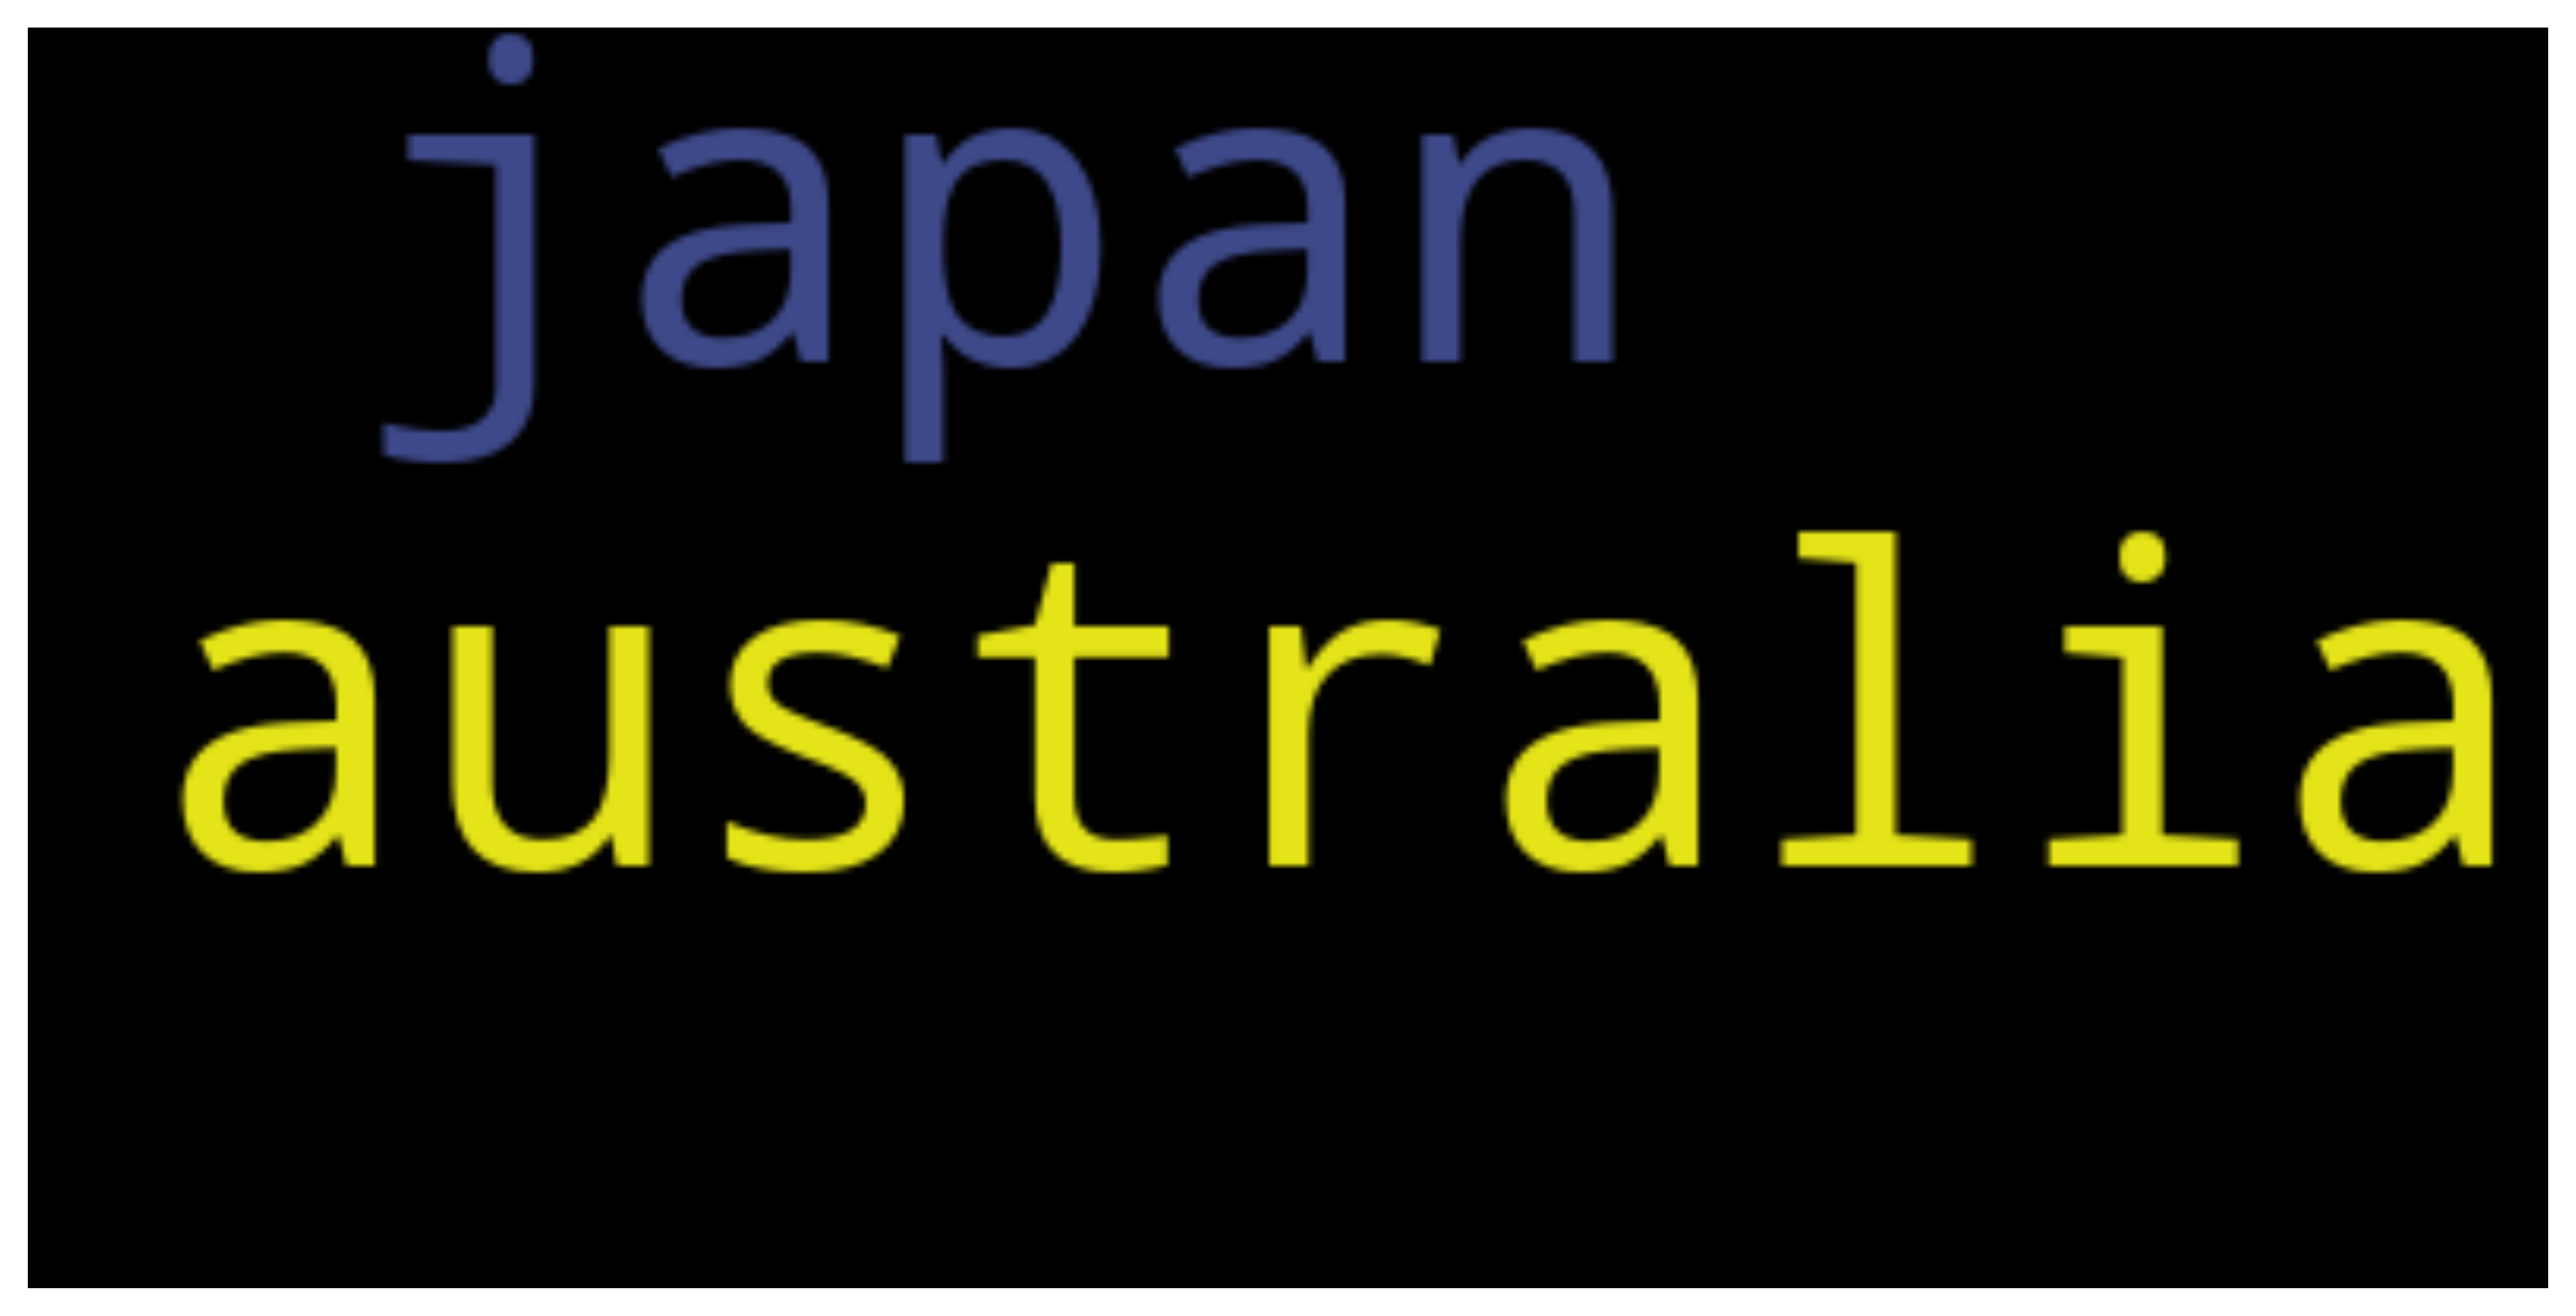

In [30]:
#illustration of NER words
text = ' '.join(data_entities_1['Entities'].to_list()) 
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(1000)
plt.show()

#### 2 - Scapy :
`pip install cloudword`

Link: https://spacy.io/

In [69]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(str_)
entities = []
labels = []
position_start = []
position_end = []
for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
data_entities_2.head()

Entities    Labels  Position_Start  \
0                                 (70s)      DATE             156   
1                               (today)      DATE             164   
2                             (english)  LANGUAGE             225   
3  (more, than, seven, million, tonnes)  CARDINAL             527   
4                         (every, year)      DATE             576   

   Position_End  
0           159  
1           169  
2           232  
3           557  
4           586

##### Cleaning entities list: 
This would be by dropping unuasable N.E.

In [70]:
#fetch the list of named entities categories 
data_entities_2.Labels.unique()

array(['DATE', 'LANGUAGE', 'CARDINAL', 'GPE', 'NORP', 'ORDINAL', 'ORG',
       'PERSON', 'PRODUCT'], dtype=object)

In [71]:
data_entities_2.drop(data_entities_2.loc[data_entities_2['Labels'] == 'CARDINAL'].index, inplace=True)
data_entities_2.drop(data_entities_2.loc[data_entities_2['Labels'] == 'DATE'].index, inplace=True)
data_entities_2.Labels.unique()

array(['LANGUAGE', 'GPE', 'NORP', 'ORDINAL', 'ORG', 'PERSON', 'PRODUCT'],
      dtype=object)

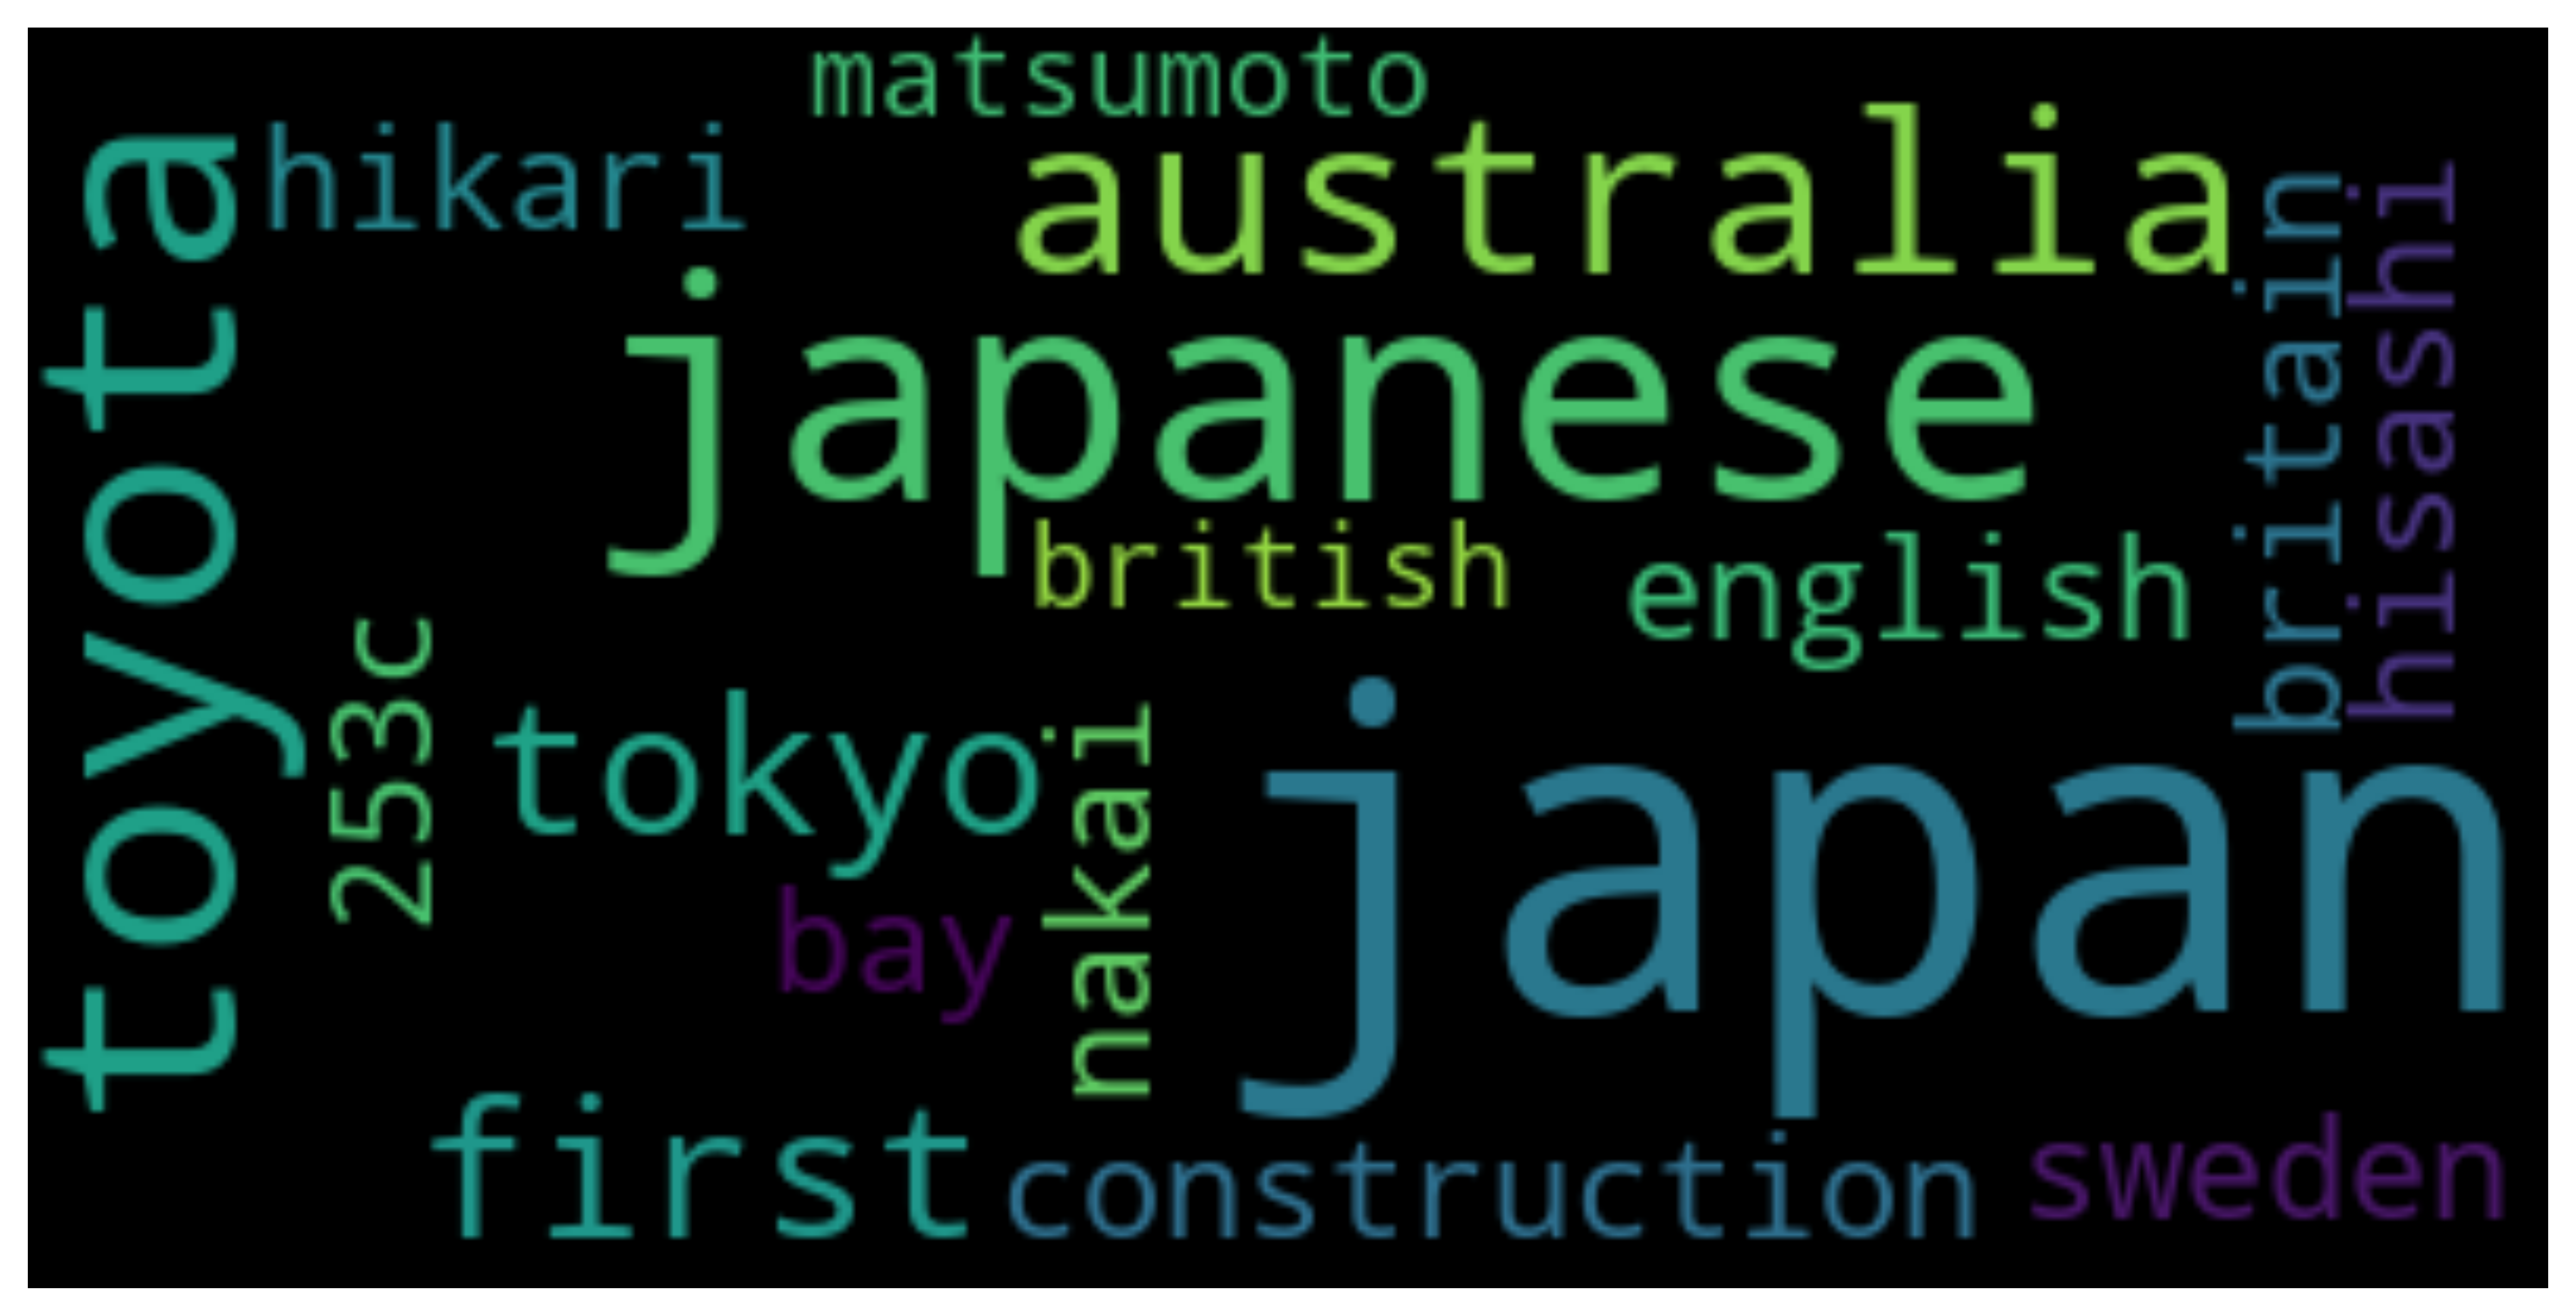

In [63]:
#illustration of NER words, might give a general idea
text = ' '.join([str(i) for i in data_entities_2['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(1000)
plt.show()


In [115]:
def get_relation(sent):
    doc = nlp(sent)
  # Matcher class object 
    matcher = Matcher(nlp.vocab)
  #define the pattern 
    patterns = [[{'DEP':'ROOT'}, {'DEP':'prep','OP':"?"}],[{'DEP':'agent','OP':"?"}, {'POS':'ADJ','OP':"?"}]] 
    matcher.add("GoogleNow", patterns)
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)
relations = [get_relation(i) for i in tqdm(Data['article_content'],'fetching nodes and relations')]

In [116]:
pd.Series(relations).value_counts()[:50]

best             32
environmental     1
dtype: int64

In [117]:
text = "it's a glorious autumn afternoon and i'm standing on a hillside looking out over tokyo bay beside me is takao saiki a usually mildmannered gentleman in his 70s\nbut today saikisan is angry\nit's a total joke he says in perfect english just ridiculous\nthe cause of his distress is a giant construction site blocking our view across the bay  a 13gigawatt coalfired power station in the making\ni don't understand why we still have to burn coal to generate electricity says saikisan's friend rikuro suzuki this plant alone will emit more than seven million tonnes of carbon dioxide every year\nsuzukisan's point is a good one shouldn't japan be cutting its coal consumption not increasing it at a time of great concern about coal's impact on the climate \nso why the coal the answer is the 2011 fukushima nuclear disaster\nin 2010 about one third of japan's electricity came from nuclear power and there were plans to build a lot more but then the 2011 disaster hit and all japan's nuclear power plants were shut down ten years later most remain closed  and there is a lot of resistance to restarting them\nin their place japan's gasfired power stations have been doing a lot of overtime but as britain has found out recently natural gas is expensive\nso the japanese government decided to build 22 new coalfired power stations to run on cheap coal imported from australia economically it made sense environmentally not so much japan is now under intense pressure to stop using coal\ninstead of closing the old coal plants and switching to renewables japan's answer is to switch to burning hydrogen or ammonia \nthe investment made by electric power companies in coalfired power plants would suddenly be useless without value in their balance sheet says prof tomas kaberger an expert on energy policy at chalmers university in sweden\nand it would create financial difficulties for electric power companies and then for banks and pension funds and that is the challenge for japan\nthe plants can be quite easily converted to burning hydrogen or ammonia neither of which produce any carbon dioxide so this seems like a good solution \nbut japan's government has much bigger ambitions than that it wants to be the world's first hydrogen economy\nthis is where the carmaker toyota comes in   \nit's another lovely sunny day and i'm in downtown tokyo at a shiny new hydrogen filling station standing on the forecourt is a sleek new toyota mirai this is a big luxury car about the size of a large lexus\ni slip into the leatherclad cabin press the start button and glide out on to the street the car is extremely smooth completely silent and the only thing dribbling on to the road behind me is a bit of water \nthe mirai which means future in japanese is toyota's first zeroemissions electric car unlike other electric cars the mirai doesn't have a huge battery under the floor instead it has a fuel cell under the bonnet and hydrogen tanks under the back seat hydrogen is combined with oxygen in a fuel cell to form water with the reaction releasing energy as electricity which runs the electric motors it's the same technology that was used to power the apollo spacecraft on the moon missions\nto many people this technology is an odd choice it's more expensive and complicated than batteries elon musk has called hydrogen cars stupid\nnot true says hisashi nakai the head of toyota's public affairs division he says the company's vision for fuel cells goes much further than just cars\ni know people have different opinions he tells me but the important thing is realising carbon neutrality we need to think about how we can make the most out of fuel cell technology we strongly believe in hydrogen as a powerful and important energy\nwhat nakaisan says shows toyota is thinking of a future where hydrogen fuel cells are everywhere in homes and offices and factories as well as cars and it wants to be at the forefront of this new hydrogen society\nthis brings us to the final and most important question where is the hydrogen to power japan zero carbon society going to come from\nthe answer is blue hydrogen\nmake hydrogen from water using renewable energy and you get green hydrogen the problem is green hydrogen is really expensive\ninstead today most hydrogen is made from natural gas or even coal that is cheap but it produces lots of greenhouse gases however if you capture those greenhouse gases and bury them in the ground you are allowed to call it blue hydrogen\nthis is exactly what japan says it is going to do\nearlier this year japan and australia opened a joint project in the state of victoria to turn a type of coal called lignite or brown coal into hydrogen the hydrogen is then liquified to minus 253c then piped into a specially built ship which carries it to japan \nwhat happens to the greenhouse gases produced at the site right now they go straight up into the atmosphere  but japan and australia are promising that at some point in the future they will begin capturing the greenhouse gas produced at the latrobe valley site and inject it into the sea floor off the coast\nclimate change campaigners are horrified by this plan they say the technology to capture and store greenhouse gases is unproven and it will lock japan into digging up vast quantities of brown coal for decades to come\naccording to prof kaberger the biggest hole in the plan is economic\ntechnically it's possible but it will always be expensive he says using fossil fuels with carbon capture and storage will always be more expensive than using fossil fuels alone and now in many parts of the world renewable electricity is already cheaper than fossil fuels without carbon capture\nprof kaberger thinks the japanese government chose blue hydrogen a decade ago when renewables were expensive and they are now locked into a plan that no longer makes sense\njapanese companies need cheap electricity to be competitive and they need clean electricity to be internationally acceptable he says that means they need renewable electricity delaying this development will harm the japanese economy\nin the meantime on the edge of tokyo bay construction continues apace the giant new coalfired power station will go online in 2023 it is expected to run for at least 40 years\ni am ashamed of japan says hikari matsumoto a 21yearold activist who has joined us to look out from the hillside \ni'm so frustrated she says in other countries young people are out on the street protesting but japanese people are so quiet our generation needs to voice its opinion\na very british scandal a gripping new drama coming soon\nletâ\x80\x99s be honest christmas can wind up the best of us"

In [122]:
entity_pairs = get_entities(text)
entity_pairs

['british  scandal', 'honest  us']

# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

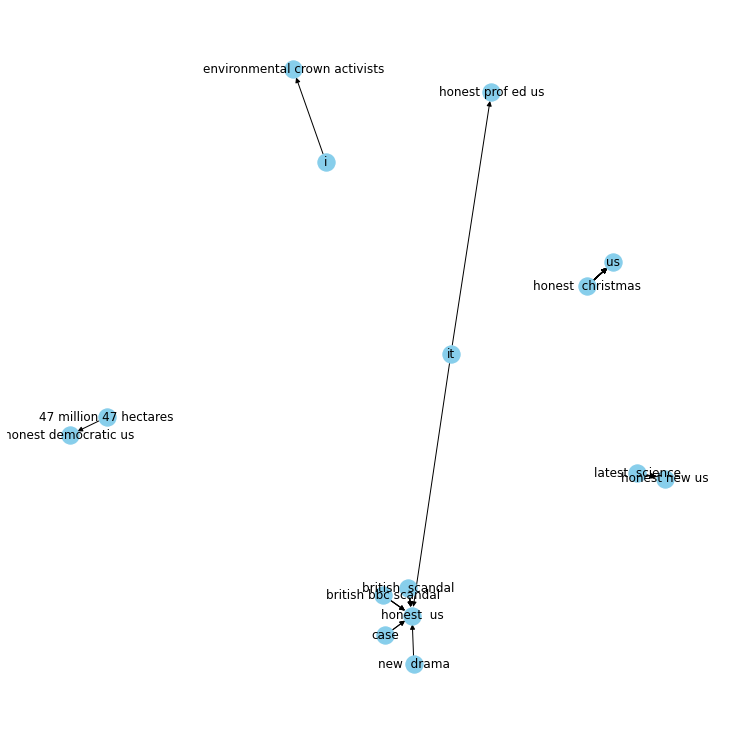

In [125]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()